13.7

This problem makes use of the Carseats dataset in the ISLP package.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from ISLP import load_data
from scipy.stats import (ttest_1samp,
                         ttest_rel,
                         ttest_ind,
                         t as t_dbn)
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multitest import multipletests as mult_test
from statsmodels.datasets import get_rdataset
import sklearn.model_selection as skm
from ISLP import load_data, confusion_table
from ISLP.models import ModelSpec as MS
from sklearn.tree import (DecisionTreeClassifier as DTC, 
                          DecisionTreeRegressor as DTR,
                          plot_tree,
                          export_text)
from sklearn.metrics import (accuracy_score,
                             log_loss)
from sklearn.ensemble import \
                             (RandomForestRegressor as RF,
                             GradientBoostingRegressor as GBR)
from ISLP.bart import BART
import warnings; warnings.simplefilter('ignore')

cars = load_data('Carseats')
cars.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


(a)

For each quantitative variable in the dataset besides Sales, fit a linear model to predict Sales using that quantitative variable. Report the p-values associated with the coefficients for the vari
ables. That is, for each model of the form $Y = 0 + 1X + \epsilon$, report the p-value associated with the coefficient 1. Here, $Y$
represents Sales and $X$ represents one of the other quantitative variables.

In [72]:
# Create a feature array with only quantitaive
# variables
feature_names = ['CompPrice','Income','Advertising','Population','Price','Age','Education']
#design = MS(feature_names[0]).fit(cars)
y = cars['Sales']
p_values = []
for a in feature_names:
    design = MS([a],intercept=True).fit(cars)
    X = design.transform(cars)
    ols = sm.OLS(y,X)
    model = ols.fit()
    p_values.append(model.pvalues[a])

In [73]:
#dir(model.pvalues)
model.pvalues[a]
p_values
d = {'Variables': feature_names, 'P Values': p_values}
df = pd.DataFrame(data = d)
df

,Variables,P Values
0,CompPrice,2.009398e-01
1,Income,2.309670e-03
2,Advertising,4.377677e-08
3,Population,3.139816e-01
4,Price,7.618187e-21
5,Age,2.788950e-06
6,Education,2.999442e-01


(b)

Suppose we control the Type I error at level $\alpha=0.05$ for the p-values obtained in (a). Which null hypotheses do we reject?

In [74]:
rej = []
p_values_sorted = np.sort(p_values)
for i in p_values:
    rej.append(np.where(i < 0.05,'Yes','No'))

df['Reject'] = rej

In [76]:
df = df.sort_values(by='P Values')
df

,Variables,P Values,Reject
4,Price,7.618187e-21,Yes
2,Advertising,4.377677e-08,Yes
5,Age,2.788950e-06,Yes
1,Income,2.309670e-03,Yes
0,CompPrice,2.009398e-01,No
6,Education,2.999442e-01,No
3,Population,3.139816e-01,No


We see that we reject Price, Advertising, Age and Income
____________________________________________________________________________________________________________________________________________

(c)

Now suppose we control the FWER at level 0.05 for the p-values. Which null hypotheses do we reject?

In [80]:
alpha = 0.05
m = len(feature_names)
print(1 - (1-alpha)**6)

0.2649081093750002


Here we use bonferoni correction to control the FWER.

In [83]:
alpha_adj = alpha/m

rej = []
p_values_sorted = np.sort(p_values)
for i in p_values_sorted:
    rej.append(np.where(i < alpha_adj,'Yes','No'))

df['Reject'] = rej

In [84]:
df

,Variables,P Values,Reject
4,Price,7.618187e-21,Yes
2,Advertising,4.377677e-08,Yes
5,Age,2.788950e-06,Yes
1,Income,2.309670e-03,Yes
0,CompPrice,2.009398e-01,No
6,Education,2.999442e-01,No
3,Population,3.139816e-01,No


We can see we are rejecting Price, advertising, age and income. Same as we did in (b).
_______________________________________________________________________________________________________________________________________________

(d)

Finally, suppose we control the FDR at level 0.2 for the p-values. Which null hypotheses do we reject?

In [93]:
q_values = mult_test(df['P Values'],alpha=0.2,method='fdr_bh')[0]
q_values
new_df = pd.DataFrame(data=d)
new_df = new_df.sort_values(by='P Values')
new_df['Reject'] = np.where(q_values == True,'Yes','No')

In [94]:
new_df

,Variables,P Values,Reject
4,Price,7.618187e-21,Yes
2,Advertising,4.377677e-08,Yes
5,Age,2.788950e-06,Yes
1,Income,2.309670e-03,Yes
0,CompPrice,2.009398e-01,No
6,Education,2.999442e-01,No
3,Population,3.139816e-01,No


We reject the same hypothesis as in (c) and (b).
______________________________________________________________________________________

13.8

In this problem, we will simulate data from m = 100 fund managers.

$\verb|
rng = np.random.default_rng(1)|$

$\verb|
n,m = 20, 100|$

$\verb|
X = rng.normal(size=(n,m))|$

These data represent each fund manager’s percentage returns for each of n = 20 months. We wish to test the null hypothesis that each fund manager’s percentage returns have population mean equal to zero. Notice that we simulated the data in such a way that each fund
manager’s percentage returns do have population mean zero; in other words, all m null hypotheses are true.

In [97]:
rng = np.random.default_rng(1)
n,m = 20, 100
X = rng.normal(size=(n,m))
X.shape

(20, 100)

(a)

Conduct a one-sample t-test for each fund manager, and plot a histogram of the p-values obtained.

Text(0, 0.5, '#')

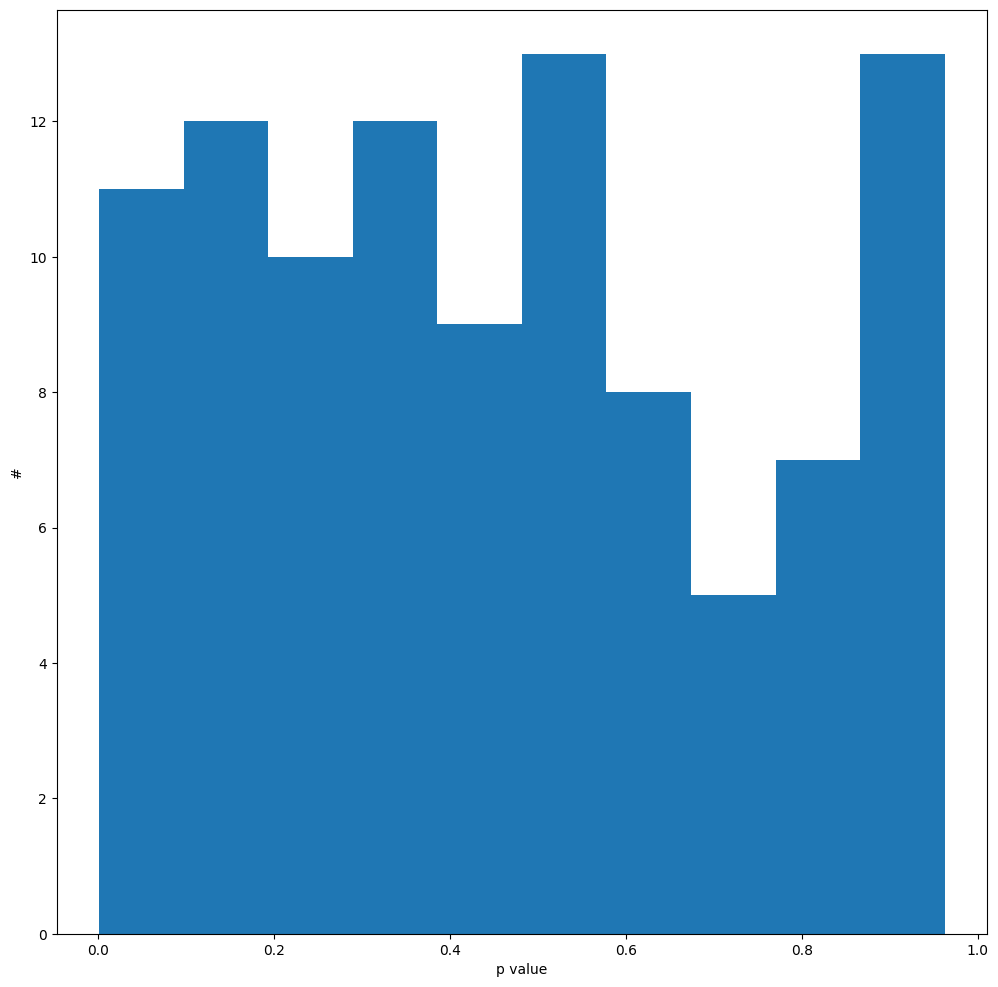

In [113]:
p_values = []
for i in range(m):
    p_values.append(ttest_1samp(X[:,i],0).pvalue)

kwargs = dict(histtype='bar', density=True, ec="k")
ax = plt.subplots(figsize=(12,12))[1]
ax.hist(p_values)
ax.set_xlabel('p value')
ax.set_ylabel('#')

(b)

If we control Type I error for each null hypothesis at level $\alpha = 0.05$, then how many null hypotheses do we reject?

In [117]:
df = pd.DataFrame({'Month 1': X[0,:],'Month 2': X[1,:],'Month 3': X[2,:],'Month 4': X[3,:],'Month 5': X[4,:],'Month 6': X[5,:],'Month 7': X[6,:],
                  'Month 8': X[7,:],'Month 9': X[8,:],'Month 10': X[9,:],'Month 11': X[10,:],'Month 12': X[11,:],'Month 13': X[12,:],'Month 14': X[13,:],
                  'Month 15': X[14,:],'Month 16': X[15,:],'Month 17': X[16,:],'Month 18': X[17,:],'Month 19': X[18,:],'Month 20': X[19,:]})
# rows correspond to each fund manager and columns correspond to each fund managers percentage returns
df

,Month 1,Month 2,Month 3,Month 4,Month 5,Month 6,Month 7,Month 8,Month 9,Month 10,Month 11,Month 12,Month 13,Month 14,Month 15,Month 16,Month 17,Month 18,Month 19,Month 20
0,0.345584,-0.651281,1.828430,-0.592775,-1.372967,-1.370340,-0.854651,-0.548941,-0.697477,-1.142957,0.194840,-0.364515,-0.335048,-0.000957,0.464254,0.388527,-0.343661,-1.219261,0.118352,-1.010099
1,0.821618,0.862445,2.020073,-0.157837,-0.551813,2.175598,0.705142,-0.629377,-0.101440,0.599558,0.838718,0.037643,-0.667573,-0.341833,0.079947,1.266830,0.616524,-2.069428,0.037558,0.165302
2,0.330437,-0.125592,-1.064771,-0.481280,-0.475219,-1.387413,1.895977,-3.548805,-2.608908,-0.876409,-0.027649,0.728849,0.138283,0.601642,2.658068,2.166993,-0.615285,-1.452518,1.387354,1.475123
3,-1.303157,0.669153,0.372815,-0.701479,1.987510,-1.077520,0.386499,-1.998604,-1.776633,0.822835,0.782432,-0.221163,-1.415526,0.382769,-1.898258,2.848904,-0.358529,-0.591962,-0.741861,0.910577
4,0.905356,1.218844,-0.673302,0.138194,-1.599184,-1.200863,0.310713,-0.532632,0.883802,1.108893,-2.575443,1.516597,-1.139328,0.236375,1.095382,1.350835,-0.084769,1.673276,-0.318666,1.682335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-2.250854,-1.617467,0.262901,-1.694992,-0.379214,-0.462462,0.563999,-0.694593,0.191187,-0.338785,-0.248536,0.701412,-1.949985,-1.031975,-0.843484,2.555964,-0.396450,-1.007309,1.265451,-0.890046
96,-0.138655,1.109638,-0.782999,0.188743,0.561030,-0.547100,-0.730844,-1.180284,0.049320,-2.418499,-0.109337,-1.226003,0.807302,-1.510245,-0.788362,0.945901,-1.634120,0.493464,1.967985,0.097742
97,0.033000,0.168106,0.668047,0.234578,-2.135831,1.259919,-1.371960,-1.783845,-2.166612,-0.076199,-0.403748,-1.623807,1.493972,-0.264494,0.329852,-0.712617,-1.323772,0.587251,-1.046726,0.426057
98,-1.425349,0.548405,1.784698,-0.865529,0.232373,0.374863,-1.694795,1.288723,0.723810,-0.397134,0.735356,-0.755420,1.216262,1.923904,-0.885983,-0.058965,-0.985335,0.528747,0.713321,0.658636


In [118]:
df['p value'] = p_values

In [126]:
rej = sum([k<=0.05 for k in p_values])
print('We reject {} null hypotheses'.format(rej))

We reject 4 null hypothesis


(c)

If we control the FWER at level 0.05, then how many null hypotheses do we reject?

In [133]:
# Here we use Holm's method for controlling the FWER
rej_holm = []
alpha = 0.05
p_values_sorted = np.sort(p_values)
for i in range(len(p_values_sorted)):
    rej_holm.append(p_values_sorted[i] < alpha/(m))

print('We reject {} null null hypotheses'.format(sum(rej_holm)))

We reject 0 null null hypotheses


(d)

If we control the FDR at level 0.05, then how many null hypotheses do we reject?

In [140]:
q_values = mult_test(p_values_sorted,alpha=0.05,method='fdr_bh')[0]
print('We reject {} null hypotheses'.format(sum(q_values)))

We reject 0 null hypotheses


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

We have again failed to reject any null hypotheses, alpha in mult_test is too small to reject any null hypotheses.
___________________________________________________________________________________________________________________________________________________________

(e)

Now suppose we “cherry-pick” the 10 fund managers who perform the best in our data. If we control the FWER for just these 10 fund managers at level 0.05, then how many null hypotheses do we reject? If we control the FDR for just these 10 fund managers at level 0.05, then how many null hypotheses do we reject?

In [150]:
# Using 'cherry-pick' on the 10 fund managers
# who perform the best (lowest p-value).
managers = ['manager {}'.format(k+1) for k in range(100)]
df = df.drop([''],axis=1)
df['manager'] = managers

In [159]:
df_new = df.sort_values(by='p value')
df_best = df_new.head(n=10)
df_best

,Month 1,Month 2,Month 3,Month 4,Month 5,Month 6,Month 7,Month 8,Month 9,Month 10,...,Month 13,Month 14,Month 15,Month 16,Month 17,Month 18,Month 19,Month 20,p value,manager
14,-0.482119,0.033928,-0.133461,-0.366267,-1.178846,-0.831655,0.128476,-0.572609,-0.039425,-0.139317,...,-1.194598,-1.402602,-0.024042,-0.456308,-2.201935,0.238636,-1.737945,-2.705317,0.000807,manager 15
44,-0.098270,0.511536,1.812230,0.202734,0.868560,-0.087248,-0.728959,0.952494,0.593480,0.792595,...,-0.067066,-0.137147,0.648240,-0.817451,1.290729,1.837783,0.221041,0.560006,0.009551,manager 45
39,0.109014,-1.123866,-1.126188,0.260948,-1.127887,0.991107,0.137527,-1.741727,0.083910,-1.827586,...,-0.977570,0.097358,-0.339035,-0.585694,-0.449985,0.377818,-0.012387,-1.361892,0.022933,manager 40
27,-0.422190,0.588969,0.518785,-0.187175,-0.611476,1.397423,2.729167,-0.981966,0.810270,1.337561,...,0.405550,-0.153465,1.685877,-0.773491,-0.539841,1.560811,0.939127,0.029864,0.035539,manager 28
72,-0.810815,-0.030028,-2.457564,-0.536352,-0.009388,0.685176,-0.418279,-0.762183,-1.004313,-1.264244,...,-0.000273,0.723916,-1.083095,0.360401,-0.427272,0.080193,-0.762866,1.262112,0.050266,manager 73
0,0.345584,-0.651281,1.828430,-0.592775,-1.372967,-1.370340,-0.854651,-0.548941,-0.697477,-1.142957,...,-0.335048,-0.000957,0.464254,0.388527,-0.343661,-1.219261,0.118352,-1.010099,0.053880,manager 1
50,0.320848,0.833343,-0.339608,-0.005500,0.912899,-1.129234,0.174167,-1.191518,-0.483777,-2.104231,...,0.610950,-1.541040,-0.525955,-1.017333,0.303440,-0.044986,-1.290939,0.317560,0.065646,manager 51
20,0.008142,1.523938,-0.293102,-0.080997,-0.139389,0.944777,1.716248,0.950437,-0.117514,0.137873,...,-0.258748,0.423881,-0.427233,0.066300,-0.689395,1.378623,-1.019121,0.435231,0.075501,manager 21
9,0.294132,-0.111292,-0.296084,0.952022,-1.002738,0.259670,-0.513016,2.021499,1.725905,0.899198,...,-0.584871,-0.580181,-0.763005,0.676620,0.476196,1.284542,1.085117,0.083461,0.077960,manager 10
35,0.663063,-0.844671,0.259563,-0.030583,-0.672473,-1.246077,-0.912098,0.447018,-1.606177,-1.504468,...,0.743546,-2.444467,-1.333053,-0.693416,0.384897,-0.650818,0.254177,0.609530,0.087938,manager 36


In [176]:
cp_pvalue = df_best['p value']
# Use Holm's method
rej = []
alpha = 0.05
m,n = df_best.shape
for i in range(len(cp_pvalue)):
    rej.append(cp_pvalue.iloc[i] < alpha/(m+1-i))
    
print("Using FWER Holm's method, we reject {} null hyptheses".format(sum(rej)))

Using FWER Holm's method, we reject 1 null hyptheses


In [178]:
q_values = mult_test(cp_pvalue,alpha=0.05,method='fdr_bh')[0]
print('Using FDR BH-procedure, we reject {} null hypotheses'.format(sum(q_values)))

Using FDR BH-procedure, we reject 2 null hypotheses


_________________________________________________________________________________________________________________________________________________________________

(f)

Explain why the analysis in (e) is misleading. Hint: The standard approaches for controlling the FWER and FDR assume that all tested null hypotheses are adjusted for multiplicity, and that no “cherry-picking” of the smallest p-values has occurred. What goes wrong if we cherry-pick?

**Answer**

By cherry-picking our data with the 10 managers with the lowest p value we have increased the risk of adding bias to our results since FWER and FDR and increased the liklihood of making Type I errors. 